### Create and Train a RNN 
to Predict a binary variable (1 or 0), whether a voltage rise (above a predefined threshold i.e. 1.0225 ) will occur or not in the next period

Seconde version of [voltageRiseBin_Train](voltageRiseBin_Train.ipynb)

Prediction using the created RNN is done here [voltageRiseBin_Pred2](voltageRiseBin_Pred2.ipynb)

---

#### Import modules to be used

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

#### Import Module for ML

In [2]:
# import pakages forML
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Import my own modules

In [3]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [4]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

In [5]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'


# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'


# Get files data 
p_mw_0013 = oriFc.readAndReshape_excelFile(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = oriFc.readAndReshape_excelFile(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = oriFc.readAndReshape_excelFile(file_p_inj_0100 ,excel_folder,)


p_mw_prod_bt_total = oriFc.readAndReshape_excelFile(file_prod_bt_total, excel_folder)
p_mw_cons_total = oriFc.readAndReshape_excelFile(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])


# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])
# Data cleaning on Consumption
previous_days = df_cons_total[(per_index>='2022 02 12') & (per_index<='2022 02 21 23:50')]
following_days = df_cons_total[(per_index>='2022 03 03') & (per_index<='2022 03 12 23:50')]
# # Put the interpolated data into the dataframe
df_cons_total[(per_index>='2022 02 21') & (per_index<='2022 03 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2


# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select relevant data up to 2022 06 01
df_prodHT = df_prodHT[df_prodHT.index<='2022 06 01 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2022 06 01 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2022 06 01 23:50']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('06:50','18:50') # for the persistance model, the previous period i.e. 06:50 
                                # is needed to compute the first instant i.e. 07:00
per_index = df_prodHT.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index<'2021 06 01']
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                        ).between_time('07:00','18:50') ).index.to_period('10T')


vm_mu_max, vm_mu_min = 1.0225, 0.95  # Choosen 


#### Import the voltage rise from [Voltage_rise](VoltageRiseBinary.ipynb)


In [6]:
# Import the voltage rise from 
bin_volt_rise = joblib.load('pickle_files/simulationResults/Binary_Voltage_Rise.pkl')

# Define a vectorise version of int to vectorise values
vect_int = np.vectorize(int)
vect_int(bin_volt_rise.known >vm_mu_max)
bin_volt_rise['Volt_Rise_Bin2'] = vect_int(bin_volt_rise.known >vm_mu_max)


### Set variables For binary voltage rise prediction

In [7]:
df_final['Volt_Rise_bin'] = bin_volt_rise['Volt_Rise_Bin2']

In [8]:
# # # Separate training and testing set 
# df_train = df_final[df_final.index<'2021 03 15']
# df_test = df_final[(df_final.index>='2021 03 15') & (df_final.index <'2021 06 01')]


# I'm using all the dataset to train the RNN to improve the performance since ive already
# tried with the testing set and get an accuraccy of 94%
# # Separate training and testing set 
df_train = df_final[df_final.index<'2021 06 01']

# Define scaler
numerical_scaler = MinMaxScaler()
numerical_scaler.fit(df_train);

# train_scaled, test_scaled= map(numerical_scaler.transform, [df_train, df_test])
train_scaled = numerical_scaler.transform(df_train)

##### Define Timeseries  generators


In [9]:
gen_length = 6 # 1 hour

batchSize = (gen_length//6)*24*7; #  (gen_length//6)  To convert in hour *24 hour * 7 days

train_generator = TimeseriesGenerator(train_scaled, train_scaled[:,-1], 
                                      length = gen_length, 
                                      batch_size= batchSize)

# test_genarator = TimeseriesGenerator(test_scaled, test_scaled[:,-1], 
#                                      length = gen_length, 
#                                      batch_size= batchSize)

n_features = train_generator[0][0][0].shape[1]  # Define total number of features

#### Define RNN

In [10]:
bin_vRise_RNN = Sequential()

bin_vRise_RNN.add( LSTM(units=128, activation='tanh', input_shape=(gen_length,n_features), return_sequences=True) )
bin_vRise_RNN.add( LSTM(units=128, activation='relu') )
bin_vRise_RNN.add(Dense(units=1, activation='sigmoid'))

bin_vRise_RNN.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

##### Define early stopping mechanism

In [11]:
early_stop = EarlyStopping(monitor= 'val_loss',patience=25, mode='min')

#### Train RNN

In [12]:
bin_vRise_RNN.fit(train_generator, 
                  epochs=100, 
                 )

Epoch 1/100
225/225 [==============================] - 6s 16ms/step - loss: 0.2051 - accuracy: 0.9243
Epoch 2/100
225/225 [==============================] - 5s 22ms/step - loss: 0.1134 - accuracy: 0.9573
Epoch 3/100
225/225 [==============================] - 6s 25ms/step - loss: 0.1028 - accuracy: 0.9638
Epoch 4/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0993 - accuracy: 0.9646
Epoch 5/100
225/225 [==============================] - 5s 24ms/step - loss: 0.0971 - accuracy: 0.9647
Epoch 6/100
225/225 [==============================] - 5s 24ms/step - loss: 0.0963 - accuracy: 0.9646
Epoch 7/100
225/225 [==============================] - 7s 29ms/step - loss: 0.0963 - accuracy: 0.9643
Epoch 8/100
225/225 [==============================] - 5s 23ms/step - loss: 0.0924 - accuracy: 0.9653
Epoch 9/100
225/225 [==============================] - 5s 24ms/step - loss: 0.0936 - accuracy: 0.9648
Epoch 10/100
225/225 [==============================] - 5s 23ms/step - loss: 0.092

<AxesSubplot:>

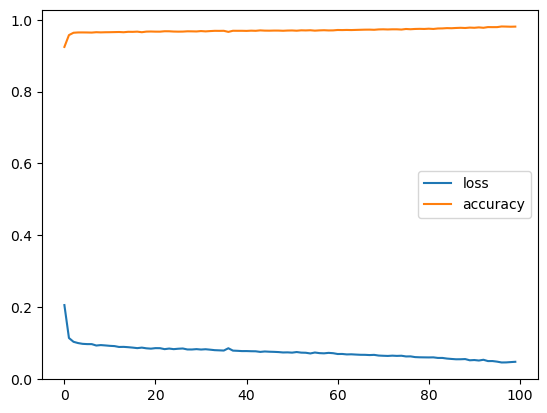

In [13]:
pd.DataFrame(bin_vRise_RNN.history.history).plot()

In [14]:
bin_vRise_RNN.save('pickle_files/RNN/StLaurent_bin_vRise_model2')
joblib.dump(numerical_scaler, 'pickle_files/RNN/StLaurent_bin_vRise_scaler2.plk')

INFO:tensorflow:Assets written to: pickle_files/RNN/StLaurent_bin_vRise_model2\assets


INFO:tensorflow:Assets written to: pickle_files/RNN/StLaurent_bin_vRise_model2\assets


['pickle_files/RNN/StLaurent_bin_vRise_scaler2.plk']